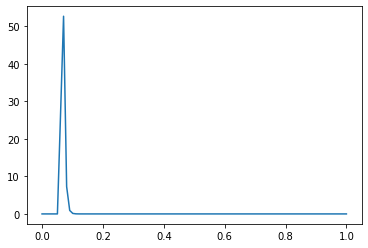

In [138]:
import numpy as np 
from scipy.special import iv
import matplotlib.pyplot as plt 
import scipy.integrate as integrate
from tqdm import tqdm
from math import erf, erfc
from scipy.optimize import *
import os 


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
def P4(r,sr):
    return (r/sr**2)*np.exp(-(r/(np.sqrt(2)*sr))**2)

def tau(S, lambd,T0=1):
    return (T0**2)*np.exp(-np.power((r/S), lambd))

def S6(lambd,W=4,T0=1,a=0.75):
    nom = 2*(T0**2)
    den = 1-(np.exp(-(2*a/W)**2)*iv(0,(2*a/W)**2))
    log = np.log(nom/den)
    return a*np.power(log,-1/lambd)

def lambd(T0=1, W=4,a=0.75):
    nom= 8*a**2
    nom*= np.exp(-(2*a/W)**2)
    nom*=iv(1,(2*a/W)**2)
    den = W**2
    den*=(1-np.exp(-(2*a/W)**2))*iv(0,(2*a/W)**2)
    
    fac1=nom/den
    
    nomlog = 2*(T0**2)
    denlog = 1-(np.exp(-(2*a/W)**2)*iv(0,(2*a/W)**2))
    inlog = np.log(nomlog/denlog)
    
    return fac1/inlog

def drdtau(S,lambd, tau,T0=1):
    return (S/lambd)*np.power(np.log(T0**2/tau),(1/lambd)-1)*(1/tau)

def prob(tau, sr, S, lambd, T0=1):
    rr = S*np.power(np.log((T0**2)/tau),1/lambd)
    return np.real(drdtau(S,lambd, tau,T0)*P4(rr,sr))

lambdaa = lambd()
S = S6(lambdaa)

taus = np.linspace(1e-5,1,100)
distt = [prob(tt, 0.4, S, lambdaa) for tt in taus]


plt.figure()
plt.plot(taus,distt)


In [137]:
S

3.770734908623806e-10

In [2]:

### CHECK ITS NORMALIZED
integrate.quad(lambda tt: prob(tt, 0.4,S, lambdaa), 0, 1)

(1.0000000000000002, 4.738319583024548e-11)

In [3]:
taus = np.linspace(.05,.15,10)
distt = [prob(tt, 0.4, S, lambdaa) for tt in taus]
probs = distt/np.sum(distt)
np.random.choice(taus,1,p=distt/np.sum(distt))

array([0.07222222])

Text(0.5, 0, '$\\tau$')

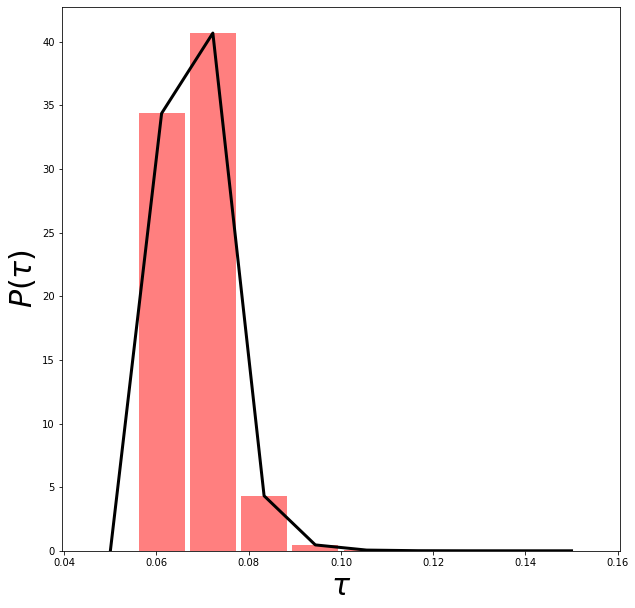

In [4]:
plt.figure(figsize=(10,10))
plt.plot(taus,distt,linewidth=3,color="black")
plt.bar(taus,distt,width=0.01,alpha=0.5,color="red")
plt.ylabel(r'$P(\tau)$',size=30)
plt.xlabel(r'$\tau$',size=30)

In [5]:
from scipy import linalg

In [5]:
def Helstrom(amplitude,Ntaus=10):
    taus = np.linspace(.05,.15,Ntaus)
    distt = [prob(tt, 0.4, S, lambdaa) for tt in taus]
    probs = distt/np.sum(distt) #to sample np.random.choice(taus,1,p=distt/np.sum(distt))
    
    new_amplitudes = np.squeeze(np.outer(np.sqrt(taus)*amplitude, [-1,1]).reshape([-1,1]))
    gram = np.zeros((len(new_amplitudes), len(new_amplitudes))) ###
    for ind1,amp1 in enumerate(new_amplitudes):
        for ind2, amp2 in enumerate(new_amplitudes):
            gram[ind1,ind2] = overlap(amp1,amp2)
            
    rho0=np.zeros(gram.shape).astype(np.complex128)
    rho1=np.zeros(gram.shape).astype(np.complex128)
    B=linalg.sqrtm(gram)
    for indtau, ptau in enumerate(probs):
        rho0+=ptau*np.outer(*[B[:,2*indtau]]*2)
        rho1+=ptau*np.outer(*[B[:,2*indtau +1]]*2)

    trace_norm = np.sum(np.abs(np.linalg.eigvals(rho0 - rho1)))/2
    helstrom_success = (1+ trace_norm)/2
    return helstrom_success

In [8]:
def homodyne_success(a):
    return (1+ erf(np.sqrt(2)*a))/2

def Homodyne(a, probs, taus):
    pp=0
    for pr, tau in zip(probs, taus):
        pp+=pr*homodyne_success(np.sqrt(tau)*a)
    return pp

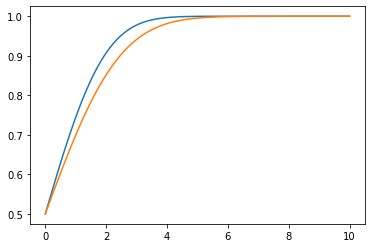

In [14]:
taus = np.linspace(.05,.15,30)
distt = [prob(tt, 0.4, S, lambdaa) for tt in taus]
probs = distt/np.sum(distt)
np.random.choice(taus,1,p=distt/np.sum(distt))

amps=np.linspace(1e-5,10,100)
plt.plot(amps,[Helstrom(a, Ntaus=len(taus)) for a in amps])
plt.plot(amps,[Homodyne(a,probs,taus) for a in amps])

In [30]:
from agent import Agent

In [16]:
def Pr(alpha, beta, bs_at, outcome, channel_params=None):
    if channel_params is None:
        p= np.exp(-abs(alpha + beta)**2)
    else:
        pis, ats = channel_params #### [[pi, 1-pi], [epsilon, 1]]
        p=0
        for pfading, at in zip(pis,ats):
           p+= pfading*np.exp(-abs(np.sqrt(at)*alpha*bs_at + beta)**2)
    if outcome==0.:
        return p
    else:
        return 1-p
    
def error_probability_1L(betas, amplitude, channel):
    b0= betas[0]
    p=0
    for n1 in [0.,1.]:
        ph = [-1,1][np.argmax([Pr(ph*amplitude, b0 ,1, n1, channel) for ph in [-1,1]])]
        p+=Pr(ph*amplitude, b0 ,1, n1, channel)/2
    return 1-p


def error_probability_2L(betas, amplitude, channel):
    b0, b1 ,b2 = betas
    p=0
    for n1,n2 in zip([0,0,1,1],[0,1,0,1]):
        bp = []
        for ph in [-1,1]:
            f=0
            for patt,att in zip(channel[0], channel[1]):
                f+=patt*agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/2
            bp.append(f)
        p+=np.max(bp)
    return 1-p

In [26]:
def give_scan(a):
    if a<1:
        betas1 = np.linspace(-1,1,10)
        lim=1
    else:
        betas1 = np.linspace(-2*a,2*a,10)
        lim=3*a
    return betas1, lim

In [21]:
fading_channel = [probs, taus]

In [24]:
betas = np.linspace(-max(amps)*2,2*max(amps),1000)
s1,fun1 = np.zeros((2,len(amps)))
s2 = np.zeros((len(amps)))
fun2 = np.zeros((len(amps),3))

for inda,a in tqdm(enumerate(amps)):

    seed = betas[np.argmin([error_probability_1L([b], a, fading_channel) for b in betas])]
    ff = minimize(error_probability_1L,x0=seed, method="BFGS", args=(a,fading_channel),bounds=[tuple([None, None])])
    #ff = dual_annealing(success_probability_1L, args=(a,fading_channel),bounds=[tuple([None, None])])

    s1[inda]= 1-ff.fun
    fun1[inda]= ff.x



0it [00:00, ?it/s]/home/cooper-cooper/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
100it [00:58,  1.71it/s]
0it [00:00, ?it/s]


NameError: name 'give_scan' is not defined

In [32]:
from agent import Agent
agent = Agent()
for inda,a in tqdm(enumerate(amps)):

    ### this led to no improvement...
    betas1, blim = give_scan(a)
    #va = [error_probability_2L([b1,b2,b3], a, fading_channel) for b1 in betas1 for b2 in betas1 for b3 in betas1]
    #seed = give_seed(betas1,va)
    ####

    f=dual_annealing(error_probability_2L,([(-blim,blim)])*3, args=[a, fading_channel], maxiter=2000,no_local_search=True, initial_temp=2000 )
    s2[inda] = 1-f.fun
    fun2[inda] = f.x

os.makedirs("data_cases/weibull/{}".format(caseid),exist_ok=True)
np.save("data_cases/weibull/{}/ar_2L_s".format(caseid),s2)
np.save("data_cases/weibull/{}/ar_2L_betas".format(caseid),fun2)

/home/cooper-cooper/Desktop/marek/agent.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.q_table = np.array(self.q_table)
/home/cooper-cooper/Desktop/marek/agent.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.n_table = np.array(self.n_table)
100it [53:05, 31.85s/it]


NameError: name 'os' is not defined

In [40]:
caseid=1
os.makedirs("data_cases/weibull/{}".format(caseid),exist_ok=True)
np.save("data_cases/weibull/{}/ar_2L_s".format(caseid),s2)
np.save("data_cases/weibull/{}/ar_2L_betas".format(caseid),fun2)
np.save("data_cases/weibull/{}/homodynes".format(caseid),homodynes_values)
np.save("data_cases/weibull/{}/helstroms".format(caseid),helstroms_values)


In [39]:
homodynes_values=[Homodyne(a,probs,taus) for a in amps]
helstroms_values = [Helstrom(a, Ntaus=len(taus)) for a in amps]

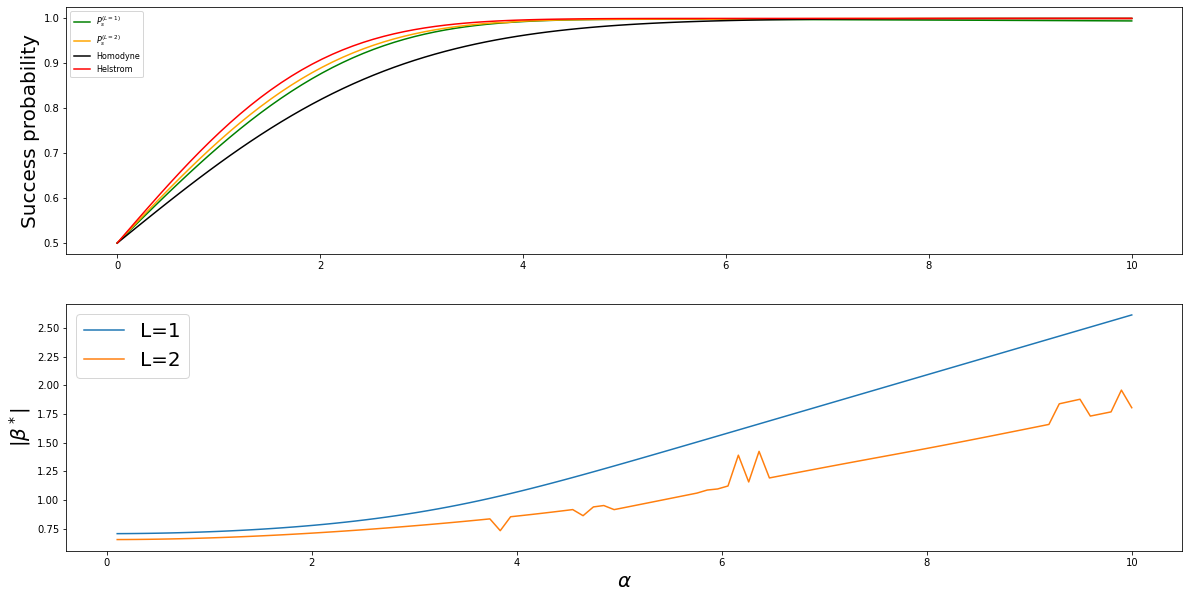

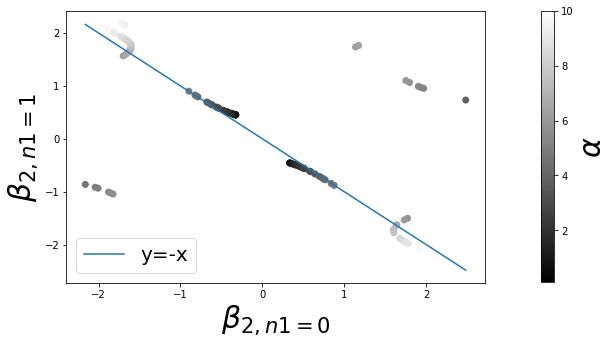

In [48]:
ind=len(amps)
fig1=plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(amps,s1, color="green",label=r'$P^{(L=1)}_s$')
plt.plot(amps,s2,color="orange", label=r'$P^{(L=2)}_s$')

plt.plot(amps,homodynes_values, color="black", label="Homodyne")
plt.plot(amps,helstroms_values, color="red", label="Helstrom")

#plt.plot(amps,[0.75]*len(amps), '--',linewidth=0.8,color="blue", label="y=0.75")
plt.ylabel("Success probability",size=20)
plt.legend(prop={"size":8})
plt.subplot(212)
plt.plot(amps[1:], np.abs(fun1)[1:],label="L=1")
#plt.plot(amps[1:], amps[1:],'--', label="y=x")
plt.plot(amps[1:],np.abs(fun2[:,0])[1:], label="L=2")
plt.legend(prop={"size":20})
plt.ylabel(r'$|\beta^*|$',size=20)
plt.xlabel(r'$\alpha$',size=20)

x = np.linspace(min(fun2[:,2]), max(fun2[:,2]),100)
fig2=plt.figure(figsize=(10,5))
im=plt.scatter(fun2[:,2][1:ind],fun2[:,1][1:ind], c=amps[1:ind],cmap="gray")#, '.',label="L=2")
cb=fig2.colorbar(im,label=r'$\alpha$',pad=0.1)
cb.set_label(label=r'$\alpha$',size=30, weight='bold')

plt.plot(x,-x, label="y=-x")
plt.xlabel(r'$\beta_{2,n1=0}$',size=30)
plt.ylabel(r'$\beta_{2,n1=1}$',size=30)

plt.legend(prop={"size":20})
plt.savefig("data_cases/weibull/{}figure.png".format(caseid))

 CASE7:
attenuations:  [0.4, 0.9]


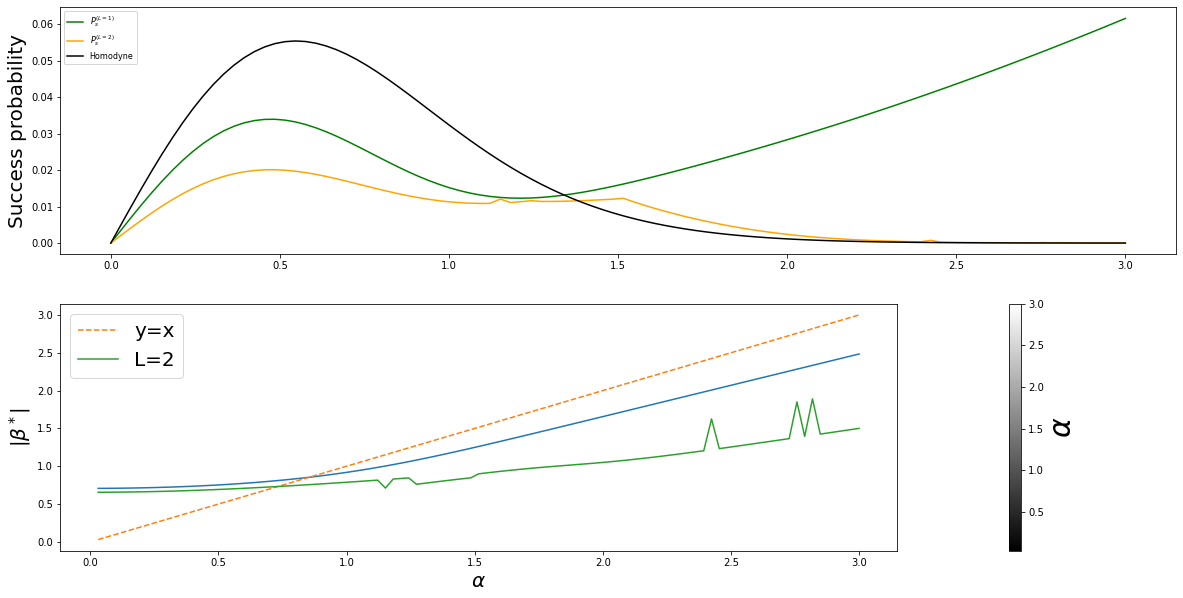

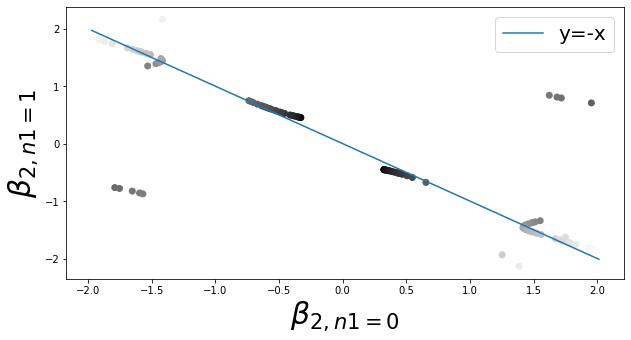

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------






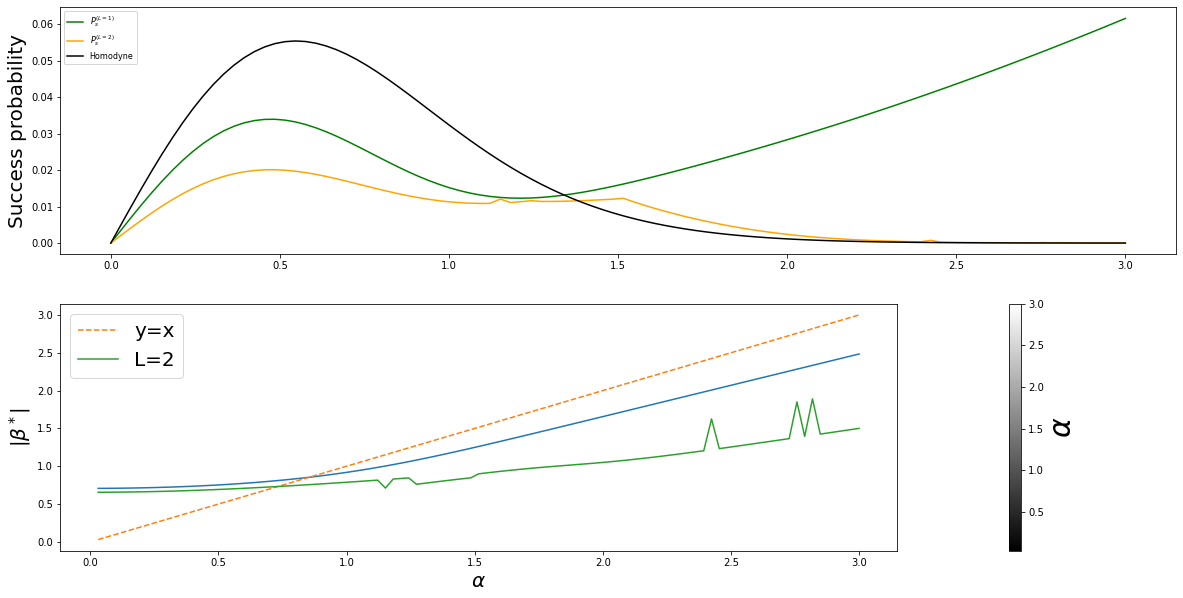

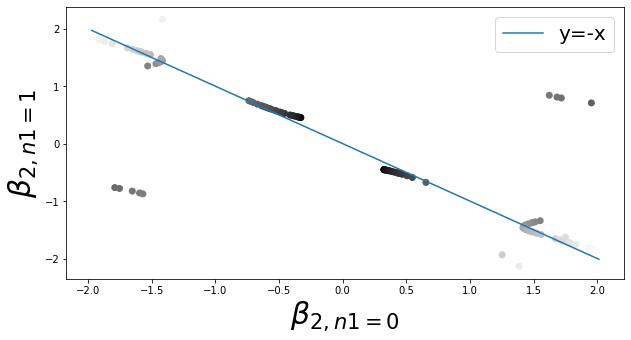

In [33]:
ind=len(amps)

channels = {}
channels[1] = [[.5,.5],[.01,1]]
channels[2] = [[.5,.5],[.9, 1.]]
channels[3] = [[.5,.5],[.5, .55]]
channels[4] = [[.5,.5],[.001, 1.]]
channels[5] = [[.5,.5],[.00001, 1.]]
channels[6] = [[.5,.5],[.000001, 1.]]
channels[7] = [[.5,.5],[.5, .9]]
channels[8] = [[.5,.5],[.3, .4]]
channels[9] = [[.5,.5],[.3, .5]]

amps=np.linspace(0,3,100)

for caseid in range(7,8):
    print("\033[1m CASE{}:".format(caseid))
    print("attenuations: ",channels[caseid][1])
    

    s2=np.load("data_cases/{}/ar_2L_s.npy".format(caseid))
    fun2=np.load("data_cases/{}/ar_2L_betas.npy".format(caseid))#,fun2)
    s1=np.load("data_cases/{}/ar_1L_s.npy".format(caseid))#,s1)
    fun1=np.load("data_cases/{}/ar_1L_betas.npy".format(caseid))#,fun1)
    homodynes_values=np.load("data_cases/{}/homodynes.npy".format(caseid))#,homodynes_values)
    helstroms_values=np.load("data_cases/{}/helstroms.npy".format(caseid))#,helstroms_values)


    fig1=plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(amps,helstroms_values-s1, color="green",label=r'$P^{(L=1)}_s$')
    plt.plot(amps,helstroms_values-s2,color="orange", label=r'$P^{(L=2)}_s$')

    plt.plot(amps,helstroms_values-homodynes_values, color="black", label="Homodyne")
    #plt.plot(amps,helstroms_values, color="red", label="Helstrom")

    #plt.plot(amps,[0.75]*len(amps), '--',linewidth=0.8,color="blue", label="y=0.75")
    plt.ylabel("Success probability",size=20)
    plt.legend(prop={"size":8})
    plt.subplot(212)
    plt.plot(amps[1:], np.abs(fun1)[1:])
    plt.plot(amps[1:], amps[1:],'--', label="y=x")
    plt.plot(amps[1:],np.abs(fun2[:,0])[1:], label="L=2")
    plt.legend(prop={"size":20})
    plt.ylabel(r'$|\beta^*|$',size=20)
    plt.xlabel(r'$\alpha$',size=20)

    x = np.linspace(min(fun2[:,2]), max(fun2[:,2]),100)
    fig2=plt.figure(figsize=(10,5))
    im=plt.scatter(fun2[:,2][1:ind],fun2[:,1][1:ind], c=amps[1:ind],cmap="gray")#, '.',label="L=2")
    cb=fig1.colorbar(im,label=r'$\alpha$',pad=0.1)
    cb.set_label(label=r'$\alpha$',size=30, weight='bold')

    plt.plot(x,-x, label="y=-x")
    plt.xlabel(r'$\beta_{2,n1=0}$',size=30)
    plt.ylabel(r'$\beta_{2,n1=1}$',size=30)

    plt.legend(prop={"size":20})
    #plt.plot(amps[1:ind],, label="L=2")
    display(fig1)
    display(fig2)
    print("---"*60)
    print("---"*60)
    
    print("\n"*3)
    

In [126]:
dots = 1.5*np.array([0.9, 0.5])
dots

array([1.35, 0.75])

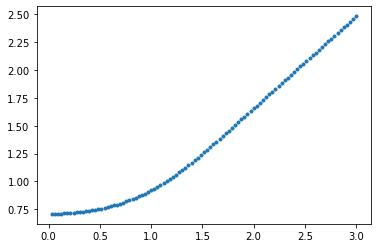

In [54]:
%matplotlib inline
plt.plot(amps[1:], np.abs(fun1)[1:],'.')


In [62]:

diff = np.abs(amps - 0.6)
inddiff = np.where(diff == np.min(diff))[0][0]
fun1[inddiff]

-0.7756086005966643

In [65]:
diff1 = np.abs(amps - 1.5)
inddiff1 = np.where(diff1 == np.min(diff1))[0][0]

In [66]:
fun2[inddiff1]

array([-0.846609  , -0.87456157, -1.56886638])

Text(0, 0.5, '$\\beta_{2,n1=1}$')

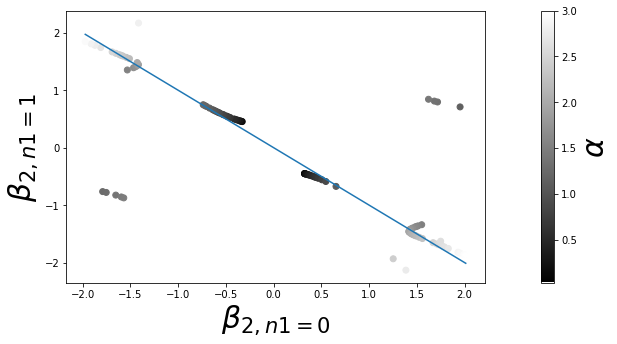

In [36]:
x = np.linspace(min(fun2[:,2]), max(fun2[:,2]),100)
fig2=plt.figure(figsize=(10,5))
im=plt.scatter(fun2[:,2][1:ind],fun2[:,1][1:ind], c=amps[1:ind],cmap="gray")#, '.',label="L=2")
cb=fig2.colorbar(im,label=r'$\alpha$',pad=0.1)
cb.set_label(label=r'$\alpha$',size=30, weight='bold')

plt.plot(x,-x, label="y=-x")
plt.xlabel(r'$\beta_{2,n1=0}$',size=30)
plt.ylabel(r'$\beta_{2,n1=1}$',size=30)


In [82]:
amps

array([0.        , 0.03030303, 0.06060606, 0.09090909, 0.12121212,
       0.15151515, 0.18181818, 0.21212121, 0.24242424, 0.27272727,
       0.3030303 , 0.33333333, 0.36363636, 0.39393939, 0.42424242,
       0.45454545, 0.48484848, 0.51515152, 0.54545455, 0.57575758,
       0.60606061, 0.63636364, 0.66666667, 0.6969697 , 0.72727273,
       0.75757576, 0.78787879, 0.81818182, 0.84848485, 0.87878788,
       0.90909091, 0.93939394, 0.96969697, 1.        , 1.03030303,
       1.06060606, 1.09090909, 1.12121212, 1.15151515, 1.18181818,
       1.21212121, 1.24242424, 1.27272727, 1.3030303 , 1.33333333,
       1.36363636, 1.39393939, 1.42424242, 1.45454545, 1.48484848,
       1.51515152, 1.54545455, 1.57575758, 1.60606061, 1.63636364,
       1.66666667, 1.6969697 , 1.72727273, 1.75757576, 1.78787879,
       1.81818182, 1.84848485, 1.87878788, 1.90909091, 1.93939394,
       1.96969697, 2.        , 2.03030303, 2.06060606, 2.09090909,
       2.12121212, 2.15151515, 2.18181818, 2.21212121, 2.24242

In [101]:
str(np.round(fun2[:,0][40],2))

'0.84'

IndexError: index 99 is out of bounds for axis 0 with size 99

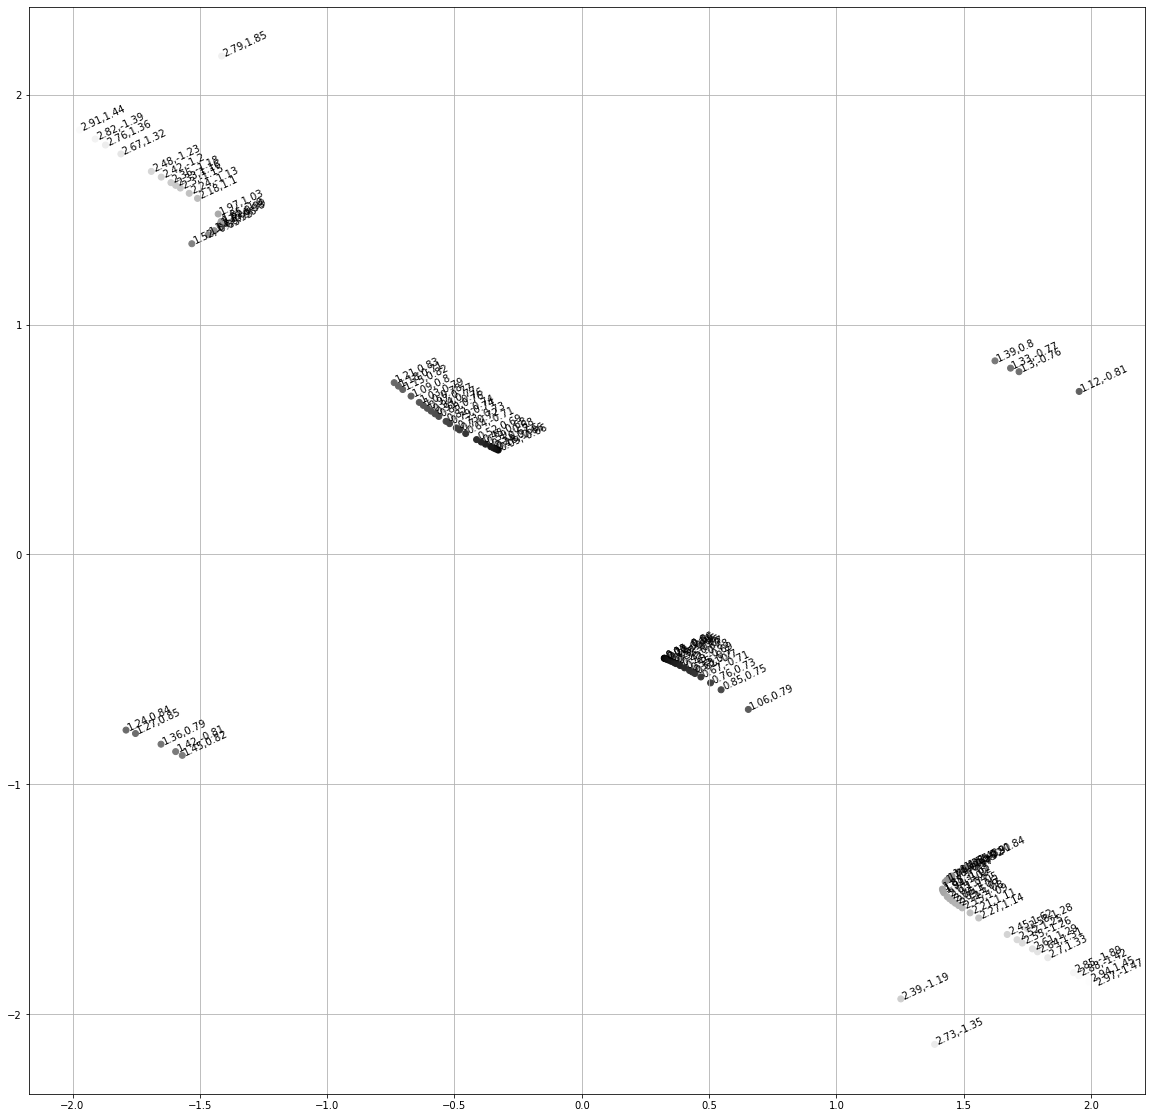

In [123]:
ind=len(amps)
x = np.linspace(min(fun2[:,2]), max(fun2[:,2]),100)
fig2=plt.figure(figsize=(20,20))
plt.grid()
im=plt.scatter(fun2[:,2][1:ind],fun2[:,1][1:ind], c=amps[1:ind],cmap="gray")#, '.',label="L=2")
x,y = fun2[:,2][1:ind1],fun2[:,1][1:ind1]


for indi in range(len(amps)):
   # if indi==0:
        
    plt.annotate(str(np.round(amps[indi+1],2)) + "," + str(np.round(fun2[:,0][indi],2)),(x[indi+1], y[indi+1] ), rotation=25)


cb=fig2.colorbar(im,label=r'$\alpha$',pad=0.1)
cb.set_label(label=r'$\alpha$',size=30, weight='bold')

plt.plot(x,-x, label="y=-x")
plt.xlabel(r'$\beta_{2,n1=0}$',size=30)
plt.ylabel(r'$\beta_{2,n1=1}$',size=30)


In [124]:
1.12*np.array([0.5,0.9])

array([0.56 , 1.008])

In [114]:
np.array([1.12*np.array([0.5,0.9]) - 0.81]) 

array([[-0.25 ,  0.198]])

In [115]:
np.array([-1.12*np.array([0.5,0.9]) - 0.81] )

array([[-1.37 , -1.818]])

In [117]:
np.array([1.12*np.array([0.5,0.9]) - 0.81])  +1

array([[0.75 , 1.198]])

In [118]:
np.array([-1.12*np.array([0.5,0.9]) - 0.81] ) + 2

array([[0.63 , 0.182]])

In [119]:
np.array([1.12*np.array([0.5,0.9]) - 0.81])  +2

array([[1.75 , 2.198]])

In [40]:
fun2[:,1][1:ind] - fun2[:,2][1:ind]

array([-0.77568403, -0.77693905, -0.77901187,  0.78191963, -0.78566119,
       -0.79024595,  0.79567232, -0.80195651,  0.80907888, -0.81706476,
        0.82591481, -0.83564052, -0.84622973,  0.85770217, -0.87006923,
        0.88331048, -0.89746056,  0.91251056, -0.92844072, -0.94528118,
       -0.96301558,  0.98164415, -1.0011595 ,  1.02155996,  1.042838  ,
       -1.06496455,  1.08793852,  1.11174392, -1.13635172,  1.16174272,
        1.18788779,  1.21476846,  1.24233387,  1.27058257,  1.29944195,
       -1.32890819,  1.35893535, -1.24453202,  1.42049164,  1.45196256,
        1.48383446,  1.0251669 ,  0.97311258, -0.92258303, -0.87366142,
        0.82637502, -0.78071565,  0.73670059,  0.69430481, -2.89254817,
        2.88301714, -2.87472271, -2.86767572, -2.86185932,  2.85728457,
       -2.85398361,  2.85199236, -2.85137066, -2.85223097,  2.85467514,
        2.85883836,  2.86483224, -2.87276886, -2.8827542 , -2.89481618,
        2.90894919, -2.92511295, -2.94321668, -2.96312055, -2.98